# Experiment 4
###Aim:Implement an image classification using pre trained models like AlexNet, VGGNet, InceptionNet, ResNet etc and compare their results

##**Importing Necessary libraries**

* From keras library we are going to use image preprocessing task, to normalize the image pixel values in between 0 to 1.
* Model is imported to load variuos Neural Netwrok models such as Sequential.
* We are going to use transfer learning technique.

In [ ]:
# import zipfile
# import os
# def unzip_dataset(zip_file_path, extraction_path):
#     if not os.path.exists(extraction_path):
#         os.makedirs(extraction_path)

#     # Open the zip file
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(extraction_path)

#     print(f"Dataset successfully extracted to {extraction_path}")

# # Example usage
# zip_file_path = '/workspace/DNN_Lab/Data/plant_village.zip'
# extraction_path = '/workspace/DNN_Lab/Data/Plant_Village'

# unzip_dataset(zip_file_path, extraction_path)

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow.keras
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras import applications
from tensorflow.keras import backend as k #allows the Keras library to work seamlessly with different deep learning backends, such as TensorFlow, Microsoft Cognitive Toolkit (CNTK).
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import  Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

##**Loading the Training and Testing Data and Defining the Basic Parameters**
* We are resizing the input image to 128 * 128

* In the dataset :
    Training Set : 70%
    Validation Set : 20%
    Test Set : 10%

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize training and validation data in the range of 0 to 1
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Read the training sample and set the batch size
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/plant_village/train',  # corrected train_datagen to '/content/train'
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical'
)

# Read Validation data from directory and define target size with batch size
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/plant_village/val',
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/plant_village/test',
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)



Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


## **Visualization of Few Images**

IndexError: index 0 is out of bounds for axis 0 with size 0

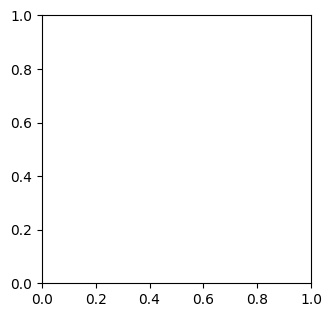

In [ ]:
plt.figure(figsize=(16, 16))
for i in range(1, 17):
  plt.subplot(4, 4, i)
  img, label = test_generator.next()
  plt.imshow(img[0])
plt.show()

In [ ]:
img, label = test_generator.next()
img[0].shape

IndexError: index 0 is out of bounds for axis 0 with size 0

##**What is ImageNet?**
ImageNet is formally a project aimed at (manually) labeling and categorizing images into almost 22,000 separate object categories for the purpose of computer vision research.

However, when we hear the term “ImageNet” in the context of deep learning and Convolutional Neural Networks, we are likely referring to the ImageNet Large Scale Visual Recognition Challenge, or ILSVRC for short.

The goal of this image classification challenge is to train a model that can correctly classify an input image into 1,000 separate object categories.

Models are trained on ~1.2 million training images with another 50,000 images for validation and 100,000 images for testing.

## **Exploring Keras Applications for Transfer Learning**

## **VGG16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape= (128, 128, 3)) # Include_top = False means excluding the model fully connected layers
base_model.trainable = False ## Not trainable weights

base_model.summary()

2024-02-05 07:42:10.334986: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-05 07:42:10.356852: E tensorflow/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-05 07:42:10.356879: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2024-02-05 07:42:10.402272: I tensorflow/core/platform/profile_utils/cpu_utils.cc:109] CPU Frequency: 2245750000 Hz
2024-02-05 07:42:10.428122: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x96303e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-02-05 07:42:10.428192: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

## **Adding top layers according to number of classes in our data**

In [ ]:
flatten_layer = layers.GlobalAveragePooling2D()
# dense_layer_1 = layers.Dense(63, activation='relu')
# dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    prediction_layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
Total params: 14,716,740
Trainable params: 2,052
Non-trainable params: 14,714,688
_________________________________________________________________


## **Training**

In [ ]:
# sgd = SGD(lr=0.001,decay=1e-6, momentum=0.9, nesterov=True)
# We are going to use accuracy metrics and cross entropy loss as performance parameters
model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = model.fit(train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/30
188/187 [==============================] - 31s 167ms/step - loss: 0.9557 - acc: 0.6219 - val_loss: 0.7215 - val_acc: 0.7906
Epoch 2/30
188/187 [==============================] - 30s 159ms/step - loss: 0.6380 - acc: 0.8185 - val_loss: 0.5273 - val_acc: 0.8709
Epoch 3/30
188/187 [==============================] - 30s 160ms/step - loss: 0.4954 - acc: 0.8641 - val_loss: 0.4290 - val_acc: 0.8976
Epoch 4/30
188/187 [==============================] - 30s 161ms/step - loss: 0.4145 - acc: 0.8914 - val_loss: 0.3672 - val_acc: 0.9197
Epoch 5/30
188/187 [==============================] - 30s 161ms/step - loss: 0.3607 - acc: 0.9054 - val_loss: 0.3256 - val_acc: 0.9276
Epoch 6/30
188/187 [==============================] - 30s 161ms/step - loss: 0.3239 - acc: 0.9164 - val_loss: 0.2938 - val_acc: 0.9339
Epoch 7/30
188/187 [==============================] - 31s 162ms/step - loss: 0.2965 - acc: 0.9211 - val_loss: 0.2705 - val_acc: 0.9339
Epoch 8/30
188/187 [==============================] - 3

## **Saving the model**

In [ ]:
model.save("VGG16_plant_deseas.h5")
print("Saved model to disk")

Saved model to disk


## **Loading the model**

In [ ]:
model = models.load_model('VGG16_plant_deseas.h5')
print("Model is loaded")

Model is loaded


## **Saving the Weights**

In [ ]:
model.save_weights('cnn_classification.h5')

## **Loading the weights**

In [ ]:
model.load_weights('cnn_classification.h5')

## **Visualization of training over epoch**

In [ ]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

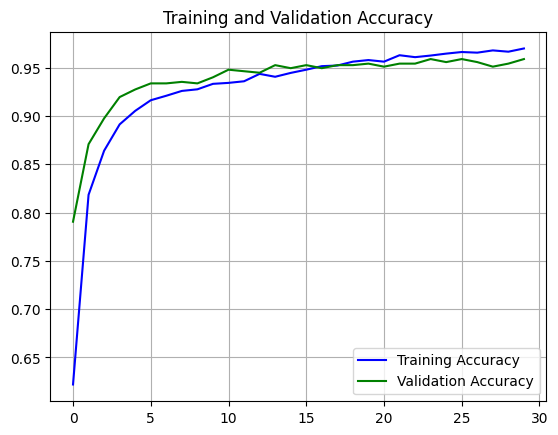

<Figure size 640x480 with 0 Axes>

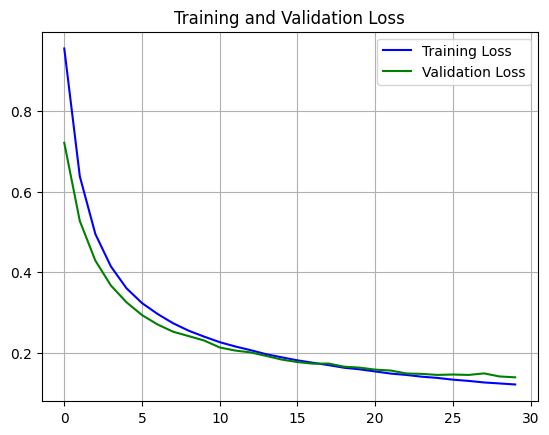

In [ ]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

## **Performance measure**

In [ ]:
# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))


546/546 [==============================] - 20s 36ms/step
No of errors = 35/546


In [ ]:
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

93.58974358974359

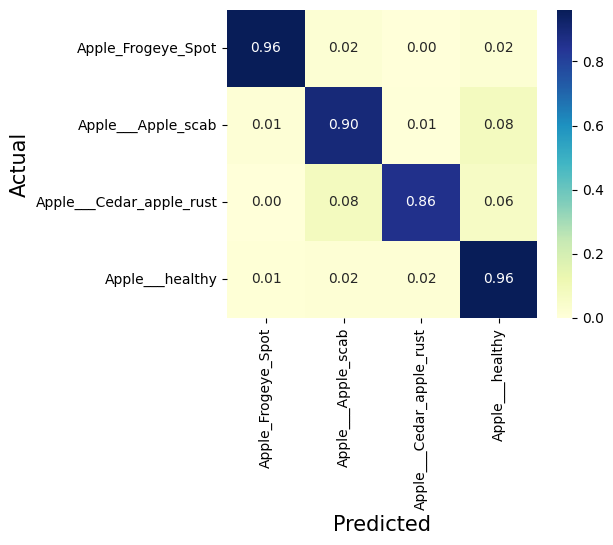

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

                          precision    recall  f1-score   support

      Apple_Frogeye_Spot       0.96      0.96      0.96       103
      Apple___Apple_scab       0.92      0.90      0.91       134
Apple___Cedar_apple_rust       0.89      0.86      0.88        49
         Apple___healthy       0.94      0.96      0.95       260

                accuracy                           0.94       546
               macro avg       0.93      0.92      0.92       546
            weighted avg       0.94      0.94      0.94       546



## **InceptionNet**

In [ ]:
from tensorflow.keras import applications

## Loading InceptionV3 model
base_model = applications.InceptionV3(weights="imagenet", include_top=False, input_shape= (128, 128, 3))
base_model.trainable = False ## Not trainable weights

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
flatten_layer = layers.GlobalAveragePooling2D()
# dense_layer_1 = layers.Dense(63, activation='relu')
# dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    # dense_layer_1,
    # dense_layer_2,
    prediction_layer
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = model.fit(train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/30
188/187 [==============================] - 25s 132ms/step - loss: 0.8921 - acc: 0.6502 - val_loss: 1.1889 - val_acc: 0.6472
Epoch 2/30
188/187 [==============================] - 21s 110ms/step - loss: 0.6012 - acc: 0.7781 - val_loss: 0.8821 - val_acc: 0.7386
Epoch 3/30
188/187 [==============================] - 21s 110ms/step - loss: 0.5454 - acc: 0.7998 - val_loss: 1.0767 - val_acc: 0.7323
Epoch 4/30
188/187 [==============================] - 21s 113ms/step - loss: 0.4854 - acc: 0.8188 - val_loss: 1.0711 - val_acc: 0.7307
Epoch 5/30
188/187 [==============================] - 22s 115ms/step - loss: 0.4732 - acc: 0.8314 - val_loss: 1.3065 - val_acc: 0.7102
Epoch 6/30
188/187 [==============================] - 20s 109ms/step - loss: 0.4702 - acc: 0.8254 - val_loss: 1.3314 - val_acc: 0.7354
Epoch 7/30
188/187 [==============================] - 21s 111ms/step - loss: 0.4397 - acc: 0.8351 - val_loss: 1.1667 - val_acc: 0.7417
Epoch 8/30
188/187 [==============================] - 2

In [ ]:
model.save("InceptionNet_plant_deseas.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

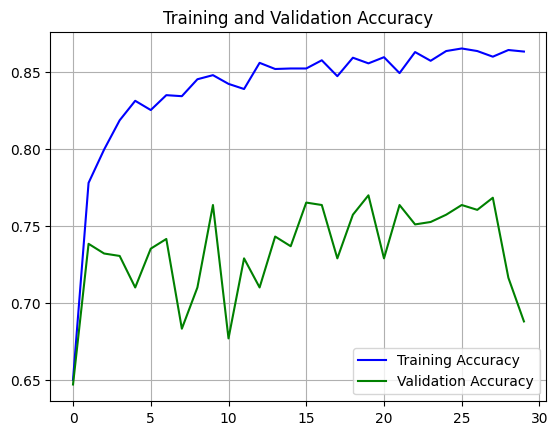

<Figure size 640x480 with 0 Axes>

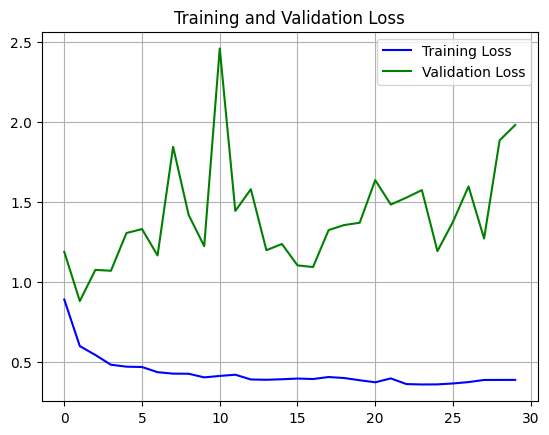

In [ ]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))


546/546 [==============================] - 13s 23ms/step
No of errors = 193/546


In [ ]:
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

64.65201465201466

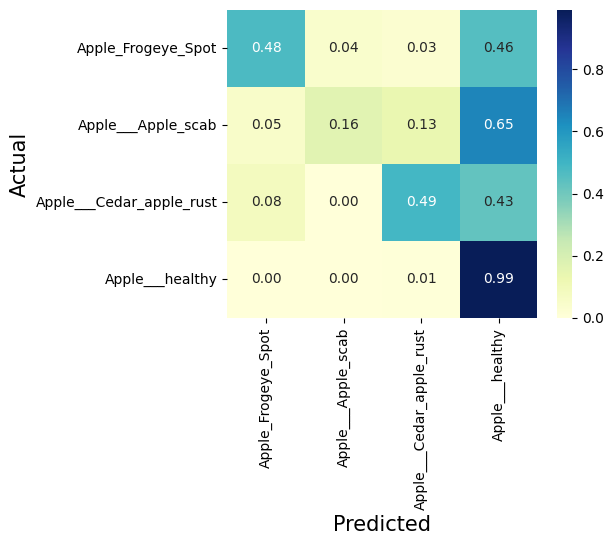

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

                          precision    recall  f1-score   support

      Apple_Frogeye_Spot       0.82      0.48      0.60       103
      Apple___Apple_scab       0.85      0.16      0.28       134
Apple___Cedar_apple_rust       0.51      0.49      0.50        49
         Apple___healthy       0.62      0.99      0.77       260

                accuracy                           0.65       546
               macro avg       0.70      0.53      0.54       546
            weighted avg       0.71      0.65      0.59       546



##**ResNet**

In [ ]:
from tensorflow.keras import applications

## Loading ResNet50 model
base_model = applications.ResNet50(weights="imagenet", include_top=False, input_shape= (128, 128, 3))
base_model.trainable = False ## Not trainable weights

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
flatten_layer = layers.GlobalAveragePooling2D()
# dense_layer_1 = layers.Dense(63, activation='relu')
# dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    # dense_layer_1,
    # dense_layer_2,
    prediction_layer
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = model.fit(train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/30
188/187 [==============================] - 37s 196ms/step - loss: 0.3678 - acc: 0.8664 - val_loss: 1.6212 - val_acc: 0.0866
Epoch 2/30
188/187 [==============================] - 33s 176ms/step - loss: 0.1417 - acc: 0.9524 - val_loss: 1.7467 - val_acc: 0.0866
Epoch 3/30
188/187 [==============================] - 32s 172ms/step - loss: 0.1264 - acc: 0.9564 - val_loss: 1.8542 - val_acc: 0.0866
Epoch 4/30
188/187 [==============================] - 32s 173ms/step - loss: 0.0830 - acc: 0.9747 - val_loss: 1.9581 - val_acc: 0.0866
Epoch 5/30
188/187 [==============================] - 32s 171ms/step - loss: 0.0674 - acc: 0.9807 - val_loss: 2.0964 - val_acc: 0.0866
Epoch 6/30
188/187 [==============================] - 32s 170ms/step - loss: 0.0634 - acc: 0.9823 - val_loss: 2.1646 - val_acc: 0.1087
Epoch 7/30
188/187 [==============================] - 32s 170ms/step - loss: 0.0602 - acc: 0.9810 - val_loss: 2.2748 - val_acc: 0.5181
Epoch 8/30
188/187 [==============================] - 3

In [ ]:
model.save("ResNet_plant_deseas.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

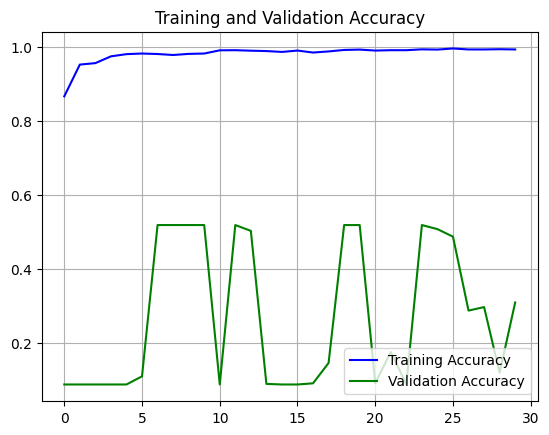

<Figure size 640x480 with 0 Axes>

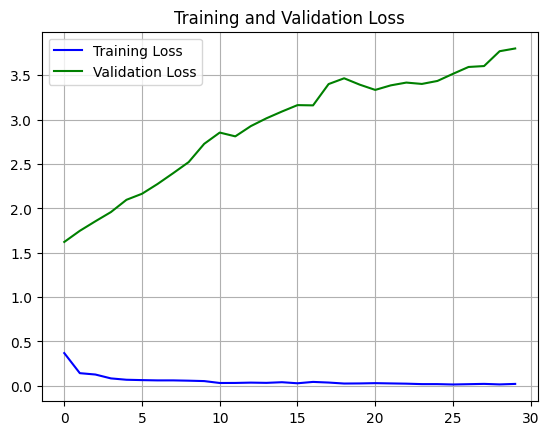

In [ ]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))


546/546 [==============================] - 18s 32ms/step
No of errors = 374/546


In [ ]:
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

31.5018315018315

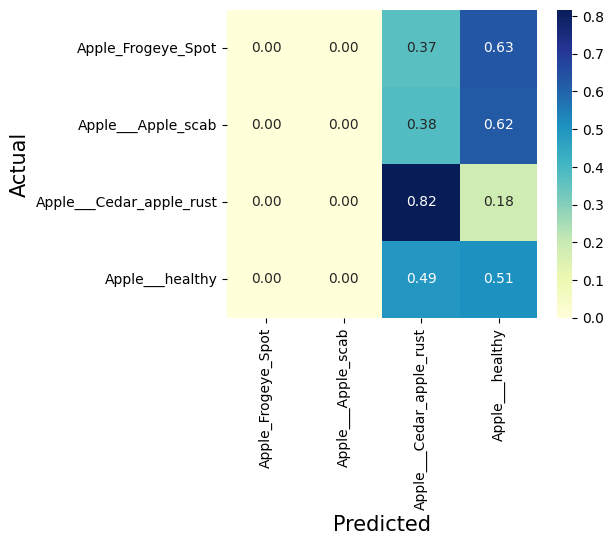

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

                          precision    recall  f1-score   support

      Apple_Frogeye_Spot       0.00      0.00      0.00       103
      Apple___Apple_scab       0.00      0.00      0.00       134
Apple___Cedar_apple_rust       0.16      0.82      0.26        49
         Apple___healthy       0.46      0.51      0.48       260

                accuracy                           0.32       546
               macro avg       0.15      0.33      0.19       546
            weighted avg       0.23      0.32      0.25       546



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Functional Model**

In [ ]:
vgg_model = VGG16(include_top=False, input_shape=(64, 64, 3))

for layer in vgg_model.layers:
    layer.trainable=False

flat1 = Flatten()(vgg_model.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(4, activation='sigmoid')(class1)

model = Model(inputs = vgg_model.inputs, outputs = output)